In [19]:
import numpy as np
from lattice_class import *
from hamiltonian_constructor_class import *
import scipy.linalg
import matplotlib.pyplot as plt

plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 150

# 1. Create Lattice

In [20]:
phase_geom = 1j
phase_vortex = -1
codim = 1

print("Vortex phase = ", phase_vortex)
print("Geometric phase = ", phase_geom)

N = 16
lattice = SquareLattice(N, "open")

lattice.remove_sites(
    [(i * N + j) for i in range(N // 2) for j in range(N // 2 + N % 2, N)]
)

flagged_bonds_geom = lattice.glue_bond(
    [(N // 2 + N % 2) ** 2 + N // (1 + N % 2) - (i + 1) for i in range(N // 2)],
    [i * (N // 2 + N % 2) + (N // 2 + N % 2) - 1 for i in range(N // 2)],
    (3, 1),
    codim=codim,
)

flagged_bonds_vortex = flagged_bonds_geom

print("Flagged geometric bonds = ", flagged_bonds_geom)
print("Flagged vortex bonds = ", flagged_bonds_vortex)

lattice_sites = lattice.get_sites()
lattice_bonds = lattice.get_bonds()
num_sites = lattice.get_num_sites()

local_bond_indices = lattice.get_local_bond_indices()


def transform(pos):
    defect_pos = ((N - 1) / 2, (N - 1) / 2)
    pos = np.array([pos[0], pos[1]])
    defect_pos = np.array([defect_pos[0], defect_pos[1]])
    pos_shift = pos - defect_pos
    x, y = pos_shift
    r = scipy.linalg.norm(pos_shift)
    angle = np.arctan2(-y, x)
    if angle < 0.0:
        angle = 2 * np.pi + angle
    angle = angle * 4 / 3
    return r * np.array([np.cos(angle), -np.sin(angle)]) + 4 / 3 * defect_pos


for itr in range(lattice.get_num_sites()):
    lattice.move_site(itr, transform(lattice._sites[itr]))

Vortex phase =  -1
Geometric phase =  1j
Flagged geometric bonds =  [(79, 7), (78, 15), (77, 23), (76, 31), (75, 39), (74, 47), (73, 55), (72, 63)]
Flagged geometric vortex =  [(79, 7), (78, 15), (77, 23), (76, 31), (75, 39), (74, 47), (73, 55), (72, 63)]


geometric_phase =  1j
vortex_phase =  -1
Lowest found energy:  0.0001760412434269593
Index of lowest absolute energy:  384


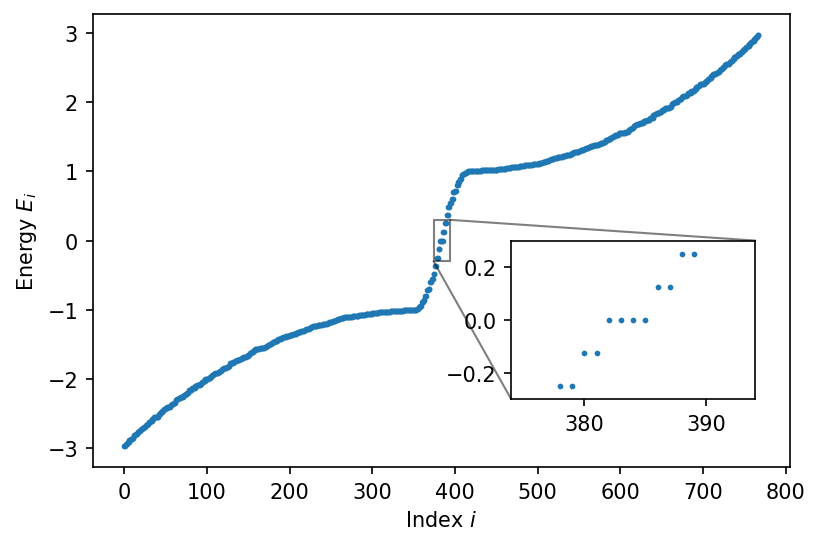

In [21]:
mu = 2
delta = complex(1.0, 0.0)
t = 1

Ham_constructor = HamiltonianConstructor(mu, t, t, delta)
H_direct_lattice = Ham_constructor.construct_direct_lattice_hamiltonian(lattice)
block_indices = Ham_constructor.get_block_indices(lattice.get_num_sites())

print("geometric_phase = ", phase_geom)
print("vortex_phase = ", phase_vortex)

for flagged_bond in flagged_bonds_geom:
    Ham_constructor.add_phase(H_direct_lattice, flagged_bond, phase_geom, num_sites)

for flagged_bond in flagged_bonds_vortex:
    Ham_constructor.add_phase(H_direct_lattice, flagged_bond, phase_vortex, num_sites)

energies, states = scipy.linalg.eigh(H_direct_lattice)

print("Lowest found energy: ", np.min(np.abs(energies)))
gs_idx = np.argmin(np.abs(energies))
print("Index of lowest absolute energy: ", gs_idx)

# Energy scatter plot with zoom window
fig, ax = plt.subplots()
plt.xlabel(r"Index $i$")
plt.ylabel(r"Energy $E_{i}$")
ax.scatter(range(len(energies)), energies, s=3)
axins = ax.inset_axes([0.6, 0.15, 0.35, 0.35])
axins.scatter(range(len(energies)), energies, s=3, zorder=-100)
x1, x2, y1, y2 = gs_idx - 10, gs_idx + 10, -0.3, 0.3
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax.indicate_inset_zoom(axins, edgecolor="black")
plt.savefig(f"./plots/discl_codim_{codim}_spectrum_n_{phase_vortex}.svg")
plt.show()

Index = 384


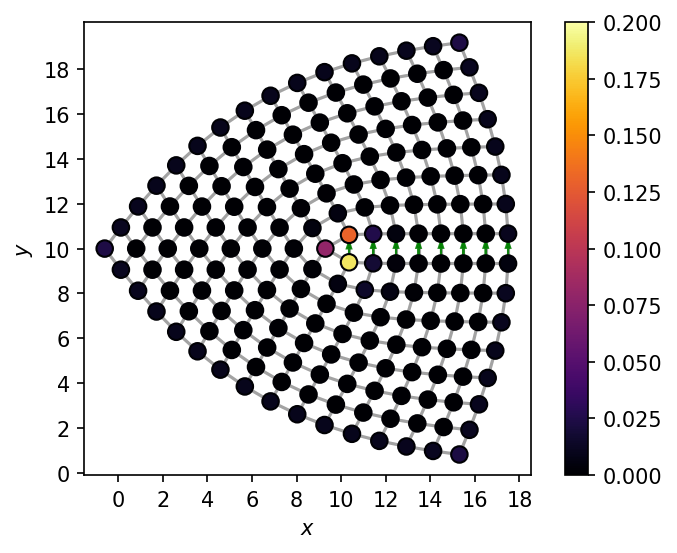

In [22]:
for gs_idx in range(gs_idx, gs_idx + 1):
    print("Index =", gs_idx)
    gs_wave_function = states[:, gs_idx]
    gs_probabilities_nambu = np.square(np.abs(gs_wave_function))
    gs_probabilities = np.zeros(shape=(num_sites, 1))

    for site_idx in range(num_sites):
        gs_probabilities[site_idx] = np.sum(
            gs_probabilities_nambu[block_indices[site_idx]]
        )

    x_values = [k[0] for k in lattice_sites]
    y_values = [k[1] for k in lattice_sites]

    color_map = plt.get_cmap("inferno")
    sc = lattice.plot(
        False, c=(gs_probabilities), flagged_bonds=flagged_bonds_vortex, cmap=color_map
    )
    plt.colorbar(sc)

    if phase_vortex > 0:
        sc.set_clim(0.0, 0.04)
    else:
        sc.set_clim(0.0, 0.2)

    plt.savefig(f"./plots/discl_codim_{codim}_prob_distr_n_{phase_vortex}.svg")
    plt.show()